<a href="https://colab.research.google.com/github/oq-Yuki-po/TensorFlowTutorial/blob/develop/%E6%98%A0%E7%94%BB%E3%83%AC%E3%83%93%E3%83%A5%E3%83%BC%E3%81%AE%E3%83%86%E3%82%AD%E3%82%B9%E3%83%88%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考URL：https://www.tensorflow.org/tutorials/keras/text_classification?hl=ja

## 目標
以下のことを行う
- 映画のレビューをそのテキストを使って肯定的か否定的かに分類
- 肯定的か否定的かに分類するニューラルネットワークを構築する（二値分類）
- ニューラルネットワークを訓練する
- モデルの性能を評価する

## 準備

### パッケージの用意

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

In [ ]:
# tensorflowのver確認
print(tf.__version__)

2.3.0


### データセットの用意
IMDBデータセットを使用する  
`num_words=10000`は最も頻繁に出現する単語10,000個を保持するためのもの  
データサイズを管理可能にするため、稀にしか出現しない単語は破棄される


In [ ]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


### データの観察

In [ ]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


データは映画レビューの中の単語を表す整数の配列と肯定か否定のラベルが付与されている  
0が否定的レビュー、1が肯定的なレビューを示す

In [ ]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [ ]:
print(train_labels[0])

1


映画のレビューはデータごとに長さが異なっている  
ニューラルネットへの入力は同じ長さにしないといけないので解決しなければならない

In [ ]:
len(train_data[0]), len(train_data[1])

(218, 189)

### 整数を単語に戻してみる

In [ ]:
# 単語を整数にマッピングする辞書
word_index = imdb.get_word_index()

# インデックスの最初の方は予約済み
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### レビューのデータをテンソルに変換

ニューラルネットに入力するデータの形を整える方法は主に２つ

- 配列をワンホット（one-hot）エンコーディングと同じように、単語の出現を表す0と1のベクトルに変換  
例えば、[3, 5]という配列は、インデックス3と5を除いてすべてゼロの10,000次元のベクトルになる  
そして、これをネットワークの最初の層、すなわち、浮動小数点のベクトルデータを扱うことができるDense（全結合）層とする  
ただし、これは単語数×レビュー数の行列が必要なメモリ集約的な方法  

- 配列をパディングによって同じ長さに揃え、サンプル数 * 長さの最大値の形の整数テンソルする  
そして、この形式を扱うことができるEmbedding（埋め込み）層をネットワークの最初の層にする

このチュートリアルでは、後者を採用

長さを標準化するのに`pad_sequences`関数を使用する  
参考：[シーケンスの前処理 - Keras Documentation](https://keras.io/ja/preprocessing/sequence/)

- value：パディングする値
- padding：パディングする位置（preまたはpost）
- maxlen：配列の長さの最大長 指定しなければ与えられた配列の中の最大長に合わせられる


In [ ]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [ ]:
# 長さが揃っていることを確認
len(train_data[0]), len(train_data[1])

(256, 256)

In [ ]:
# パディング済みの最初のデータを確認
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## モデルの構築

1.   Embedding（埋め込み）層
    > keras.layers.Embedding  
    > 整数にエンコードされた語彙を受け取り、それぞれの単語インデックスに対応する埋め込みベクトルを検索する
    > 埋め込みベクトルは、モデルの訓練の中で学習される  
    > ベクトル化のために、出力行列には次元が１つ追加される  
    > その結果、次元は（batch, sequence, embedding）となる  
    > 簡単に言うと、文章を入力として各々の単語をベクトル表現したものを返す
2.   GlobalAveragePooling1D（１次元のグローバル平均プーリング）層
    > keras.layers.GlobalAveragePooling1D  
    > GlobalAveragePooling1D（１次元のグローバル平均プーリング）層  
    > それぞれのサンプルについて、シーケンスの次元方向に平均値をもとめ、固定長のベクトルを返す
    > 簡単に言うと、単語のベクトルの次元ごとに平均値を取る（情報量の圧縮）
3.   全結合層の定義
    > 16個の隠れユニットを持つ全結合層
    > activation='relu'は活性化関数ReLUを指定している  
4.   全結合（分類）層の定義
    > １つの出力ノードに全結合をする
    > 活性化関数にシグモイド（sigmoid）を使用することで、出力される値は確率あるいは確信度を表す０と１の間の浮動小数点となる

In [ ]:
# 入力の形式は映画レビューで使われている語彙数（10,000語）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### 隠れユニット

上記のモデルには、入力と出力の間に、2つの中間層あるいは「隠れ」層がある  
出力（ユニット、ノード、またはニューロン）は、その層の内部表現の次元数  
言い換えると、このネットワークが学習によって内部表現を獲得する際の自由度ということ  

モデルにより多くの隠れユニットがある場合（内部表現空間の次元数がより大きい場合）、  
または、より多くの層がある場合、あるいはその両方の場合、ネットワークはより複雑な内部表現を学習することができる  
しかし、その結果として、ネットワークの計算量が多くなるほか、学習してほしくないパターンを学習するようになる  
学習してほしくないパターンとは、訓練データでの性能は向上するもののテスト用データの性能が向上しないパターン  
この問題を過学習（overfitting）という

### モデルのコンパイル

学習のためのモデルを定義している

- optimizer：最適化アルゴリズム
    - 今回は`Adam`を指定
    - その他の最適化アルゴリズム：https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- loss：損失関数
    - 今回は`２値の交差エントロピー`を指定
- metrics：学習及びテスト中に定量化される項目
    - 今回は`accuracy（正確性）`を指定

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 検証

### 検証用のデータを作成  

訓練を行う際、モデルが見ていないデータでの正解率を検証する  
もとの訓練用データから、10,000個のサンプルを取り分けて検証用データ（validation set）を作成する  
検証用のデータはモデル構築時のハイパーパラメータの調整などに使用する  

In [ ]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### モデルの学習

512個のサンプルからなるミニバッチを使って、40エポックモデルを訓練する  
この結果、x_trainとy_trainに含まれるすべてのサンプルを40回繰り返すことになる  
訓練中、検証用データの10,000サンプルを用いて、モデルの損失と正解率をモニタリングする

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 21ms/step - loss: 0.6916 - accuracy: 0.5446 - val_loss: 0.6894 - val_accuracy: 0.6478
Epoch 2/40
30/30 [==============================] - 0s 16ms/step - loss: 0.6855 - accuracy: 0.7160 - val_loss: 0.6815 - val_accuracy: 0.6852
Epoch 3/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6726 - accuracy: 0.7333 - val_loss: 0.6651 - val_accuracy: 0.7548
Epoch 4/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6499 - accuracy: 0.7683 - val_loss: 0.6393 - val_accuracy: 0.7636
Epoch 5/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6166 - accuracy: 0.7867 - val_loss: 0.6045 - val_accuracy: 0.7791
Epoch 6/40
30/30 [==============================] - 1s 17ms/step - loss: 0.5747 - accuracy: 0.8083 - val_loss: 0.5650 - val_accuracy: 0.7975
Epoch 7/40
30/30 [==============================] - 0s 16ms/step - loss: 0.5286 - accuracy: 0.8265 - val_loss: 0.5212 - val_accuracy: 0.8165
Epoch 8/40
30

### モデルの評価

2つの値が返される
- 損失（エラーを示す数値であり、小さい方が良い）
- 正解率

In [ ]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3297 - accuracy: 0.8723
[0.32968297600746155, 0.8723199963569641]


### 正解率と損失の時系列グラフを描く

学習の経過を可視化する  
どのように学習が進んでいるのかを可視化することで過学習などを起こしているか見つけやすくなる  
`model.fit()` は、訓練中に発生したすべてのことを記録した辞書を含むHistory オブジェクトを返す

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

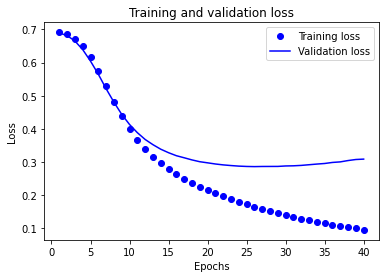

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

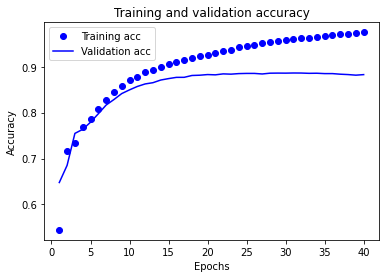

In [ ]:
plt.clf()   # 図のクリア

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

上記のグラフでは、点が訓練時の損失と正解率を、実線が検証時の損失と正解率をしている

20エポックを過ぎたあたりから横ばいになっている  
これが、過学習の一例となる  
モデルの性能が、訓練用データでは高い一方で、見たことの無いデータではそれほど高くない
このポイントをすぎると、モデルが最適化しすぎて、訓練用データでは特徴的であるが、テスト用データには一般化できない内部表現を学習している  

このケースの場合、20エポックを過ぎたあたりで訓練をやめることで、過学習を防止することができる  
過学習の防止は、callbackを使用または正則化を行う